<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/7_Linear_multiclass_classification/7_2_OvA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 7: Linear multi-class classification

# 7.2  One-versus-All Multi-Class Classification

In practice many classification problems have more than two classes we wish to distinguish, e.g., face recognition, hand gesture recognition, general object detection, speech recognition, and more.  However because it has only two sides, a single linear separator is fundamentally insufficient as a mechanism for differentiating between more than two classes of data. Nonetheless we can use our understanding of two-class classification to overcome this shortcoming when dealing with $C>2$ classes by learning $C$ linear classifiers (one per class), each distinguishing one class from the rest of the data. 

The heart of the matter is how we should combine these individual classifiers to create a reasonable multi-class decision boundary. In this Section we develop this basic scheme - called *One-versus-All* multi-class classification - step-by-step by studying how such an idea should unfold on a toy dataset. With due diligence and a little common sense we can intuitively derive universal ideas regarding multiclass classification that are the basis for most popular multi-class classification schemes, including One-versus-All (OvA) classification.

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_7_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/7_Linear_multiclass_classification/chapter_7_library
    else:
        print('chapter_7_library already cloned!')

    # clone library subdirectory
    if not Path('chapter_7_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/7_Linear_multiclass_classification/chapter_7_datasets
    else:
        print('chapter_7_datasets already cloned!')

    # clone datasets
    if not Path('chapter_7_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/7_Linear_multiclass_classification/chapter_7_images
    else:
        print('chapter_7_images already cloned!')
        
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_7_library') 

# import section helper
import section_7_2_helpers

# datasets
dataset_path_1 = 'chapter_7_datasets/3class_data.csv'
dataset_path_2 = 'chapter_7_datasets/4class_data.csv'

# imports
from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Notation and modeling

A multiclass dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$
consists of $C$ distinct classes of data. As with the two class case we can in theory use *any $C$ distinct labels* to distinguish between the classes.  For the sake of this derivation it is convenient to use label values $y_{p}\in\left\{ 0,1,...,C-1\right\} $, which is what we will use throughout this Section.  

Below we show a prototypical toy $C = 3$ class dataset we will use in our derivation of OvA.  Afterwards we will apply what we have developed to other datasets as well.  Here the points colored blue have label value $y_p = 0$, those colored red have label value $y_p = 1$, and those colored green have label value $y_p = 2$.

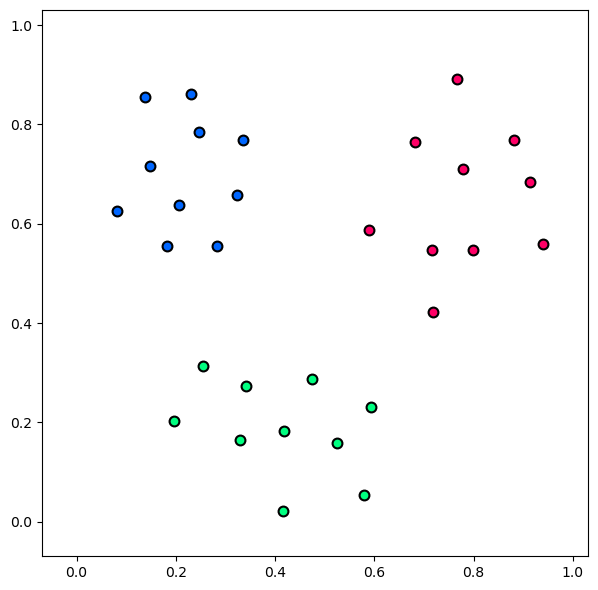

In [2]:
# load in dataset
data = np.loadtxt(dataset_path_1,delimiter = ',')

# create an instance of the ova demo
demo1 = section_7_2_helpers.OvaVsualizer(data)

# visualize dataset
demo1.show_dataset()

##  Training  $C$ One-versus-All classifiers

The first step of OvA classification is simple - we reduce the new problem of multi-class classification into a sequence of smaller problems that we are already familiar with. If we reflect for a moment on what we want, one way of phrasing the goal of multi-class classification is that *we want to learn how to distinguish each class of our data from the other $C-1$ classes*.  From this perspective it certainly seems that a good first step towards accomplishing our goal would be to learn $C$ two-class classifiers on the entire dataset, with the $c^{th}$ classifier trained to distinguish the $c^{th}$ class from the remainder of the data.  With the $c^{th}$ two-class subproblem we simply assign temporary labels $\tilde y_p$ to the entire dataset, giving $+1$ labels to the $c^{th}$ class and $-1$ labels to the remainder of the dataset

\begin{equation}
\tilde y_p = \begin{cases}   +1 \,\,\,\,\,\,\text{if}\,\, y_p = c \\ -1 \,\,\,\,\,\,\text{if}\,\, y_p \neq c    \end{cases}
\end{equation}

where again $y_p$ is the original label for the $p^{th}$ point, and run the two-class classification scheme of our choice.

Doing this for our $C = 3$ dataset in this case we end up learning 3 linear classifiers - here we use logistic regression for each subproblem, solving each using Newton's method. 

With our classifiers trained we can now illustrate our learned decision boundaries - each learned to distinguish a single class from the remainder of the data. Below we plot two rows of images - in the top row our original dataset is plotted three times with each instance showing just one of the three two-class classifiers learned.  The single class being distinguished is colored with its original color - with the corresponding learned decision boundary colored similarly - and all other data is colored gray. In the bottom row the dataset is shown with along with all three learned decision boundaries all at once.

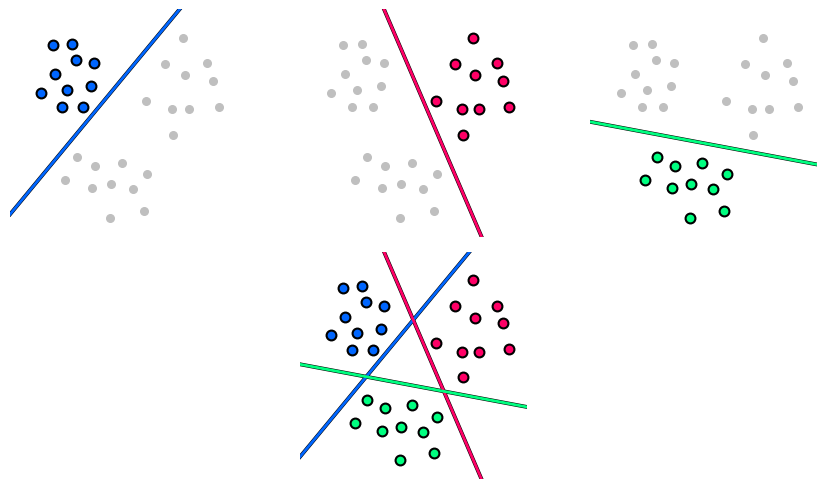

In [3]:
# solve the 2-class subproblems
demo1.solve_2class_subproblems()

# illustrate dataset with each subproblem and learned decision boundary
demo1.plot_data_and_subproblem_separators()

##   Points on the positive side of a single classifier

With OvA we learn $C$ two-class classifiers, and we can denote the weights from the $c^{th}$ classifier as $\mathbf{w}_c$ where


\begin{equation}
\mathbf{w}_c=\begin{bmatrix}
w_{0,c}\\
w_{1,c}\\
w_{2,c}\\
\vdots\\
w_{N,c}
\end{bmatrix}
\end{equation}

and then the corresponding decision boundary as 

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c = 0.
\end{equation}

Now note how in the figure above how in each case - because each subproblem is perfectly linearly separable and because of our choice of temporary labels - that the class to be distinguished from the rest lies on the *positive side* of its respective classifier, with the remainder of the points lying on the *negative side*.  This of course means that for the $j^{th}$ classifier we have for the $p^{th}$ point $\mathbf{x}_p$ that

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c  \begin{cases}   > 0 \,\,\,\,\,\,\text{if}\,\,\, y_p = c  \\ < 0 \,\,\,\,\,\, \text{if} \,\,\, y_p \neq c.    \end{cases}
\end{equation}

This implies that - when evaluated by each two-class classifier individually - the one identifying a point's true label always provides the largest evaluation, i.e.,

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j  = \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c 
\end{equation}


So we know how to classify the points that we have, what about those we do not?  How do we classify arbitrary points in the space of our example?  Lets figure this out step-by-step.  

First, those points that lie solely on the positive side of the $j^{th}$ classifier only - like the points we already have - should clearly belong to the $j^{th}$ class.  Such a point $\mathbf{x}$ lies close to those we already have, also clearly satisfying the condition that 

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j = \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c
\end{equation}

Therefore to get the associated label $y$ we therefore want the *maximum argument* of the right hand side - since this gives the index associated with the largest classifier.  Formally then the predicted label $y$ for input point $\mathbf{x}$ here can be written as

\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c
\end{equation}

We color in the points representing these areas of the space of our dataset in the Python cell below.  

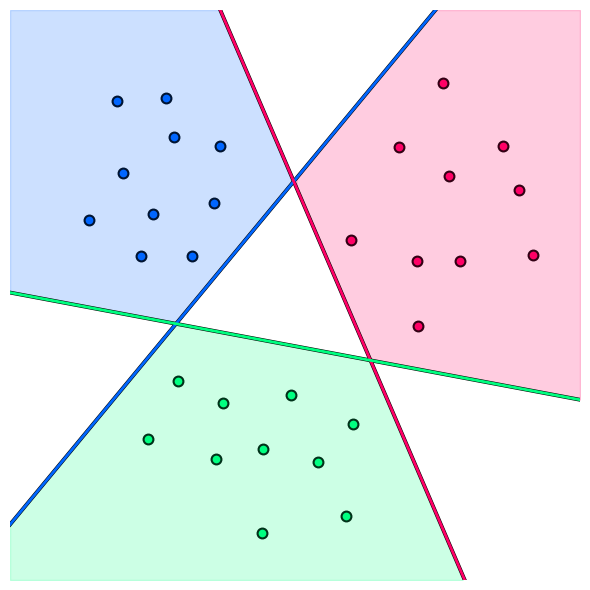

In [4]:
# color those points clearly belonging to each individual class - those lying near the points we already have on the positive side of only one classifier.
demo1.show_fusion(region = 1)

## Points on the positive side of more than one classifier

Notice there are regions left uncolored above that do not fall into this first category (of being on the positive side of a single classifier). These include regions where points are on the positive side of more than one classifier - these are the three triangular white regions bordered by *two* decision boundaries. For example points in the white region at the top - bordered by the red and blue decision boundaries - are on the positive side of both the red and blue classifiers. The un-colored regions also include the one in the very middle of the plot whose points are on the negative side of all three classifiers.

Let us first determine how to appropriately classify points in those un-colored regions where more than one classifier is positive. We deal with the case where a point ends up on the negative side of all classifiers in the next Subsection. For simplicity, here we only consider the top region that is on the positive side of both the red and blue classifiers (the other regions should behave similarly). 

In the Python cell below we show two example points in this region. In each case we plot the original dataset and individual classifiers along with new point in question in black. We also highlight the distance from the new point to both decision boundaries in dashed black, with the projection of the point onto each decision boundary shown as an 'X' in the same color as its respective hyperplane.

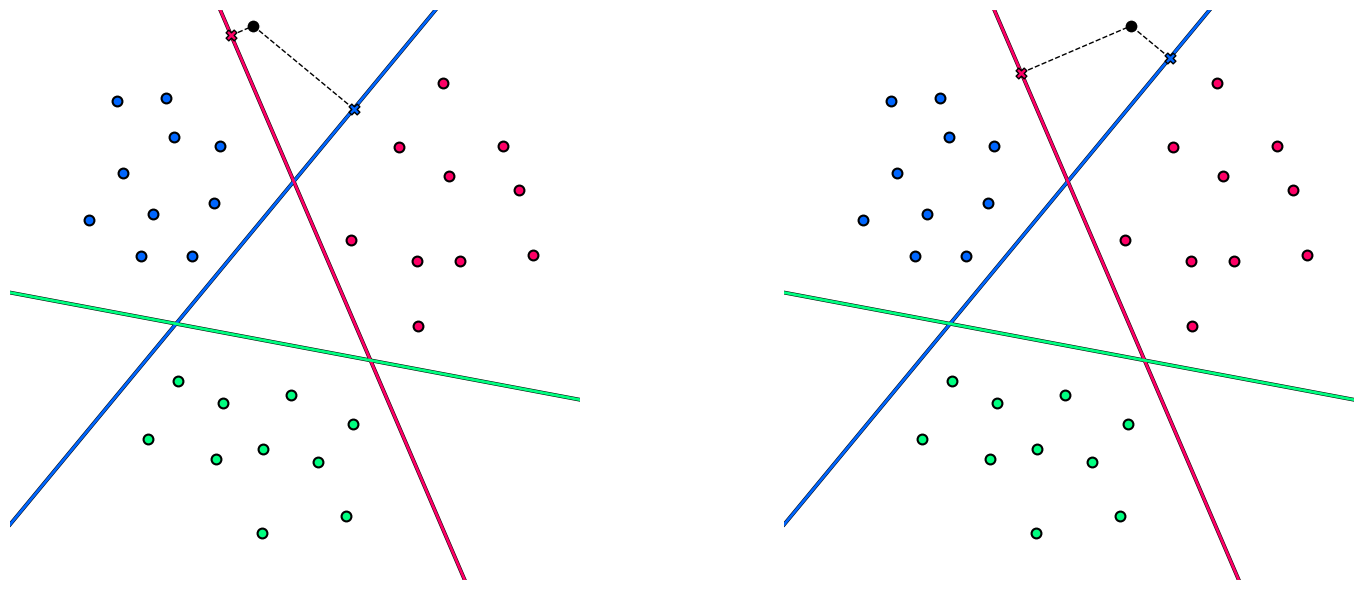

In [5]:
# try examining a point and its distance to relevant decision boundaries
demo1.point_and_projection(point1 = [0.4,1] ,point2 = [0.6,1]);

Beginning with the point shown on the left, which class should we assign this point to?

Recall, when we discussed logistic regression, that we think of a classifier as being 'more confident' of the class identity of given a point the *farther* the point lies from the classifier's decision boundary. This is a simple geometric/ probabilistic concept, the bigger a point's distance to the boundary the deeper into one region of a classifier's half-space it lies, and thus we can be much more confident in its class identity than a point closer to the boundary. Another way we can think about it - imagine if we slightly perturbed the decision boundary: those points originally close to its boundary might end up on the other side of the perturbed hyperplane, changing classes, whereas those points farther from the boundary are less likely to be so affected (hence we can be more confident in their class identities to begin with).

With this in mind, which classifier can we say is more confident about this point?  The answer is the red one since our input point lies a greater distance from it. 

What about the point shown in the right panel? By the same logic it is best assigned to the blue class, being at a greater distance from the blue classifier.

If we repeat this logic for every point in the region - as well as those points in the other two regions where two or more classifiers are positive - and color each point the color of its respective class, we will end up shading each such region as shown by the Python cell below.

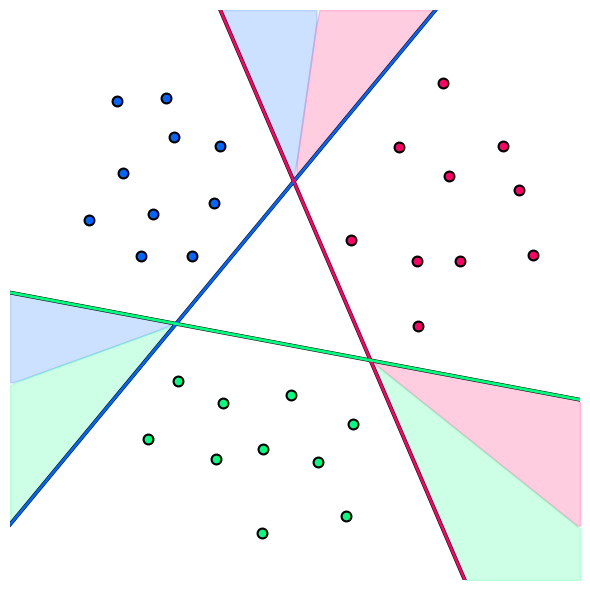

In [6]:
# color points belonging on the positive side of two or more classifiers
demo1.show_fusion(region = 2)

And how do those points equidistant to two or more decision boundaries get assigned to a class?  In the same way points lying on a two-class decision boundary do: we assign a class label at random. These points form the *multi-class decision boundary*.

How do we formalize this rule? In these regions we have assigned each point to the class whose boundary is at the *largest nonnegative* distance from it.  How do we compute the distance of an arbitrary point to each of our decision boundaries?

As we saw in [Section 6.3](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_3_Softmax.html), the *signed distance* of an arbitrary point $\mathbf{x}$ to the $j^{th}$ linear decision boundary is equal to the evaluation at this boundary *provided we normalize its parameters by the magnitude of its feature-touching weights* (which is also the *normal vector* to the separating hyperplane).  We can express this by using notation that exposes the bias and feature-touching weights of each classifier 

\begin{equation}
\text{(bias):}\,\, b_j = w_{0,j} \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega}_j = 
\begin{bmatrix}
w_{1,j} \\
w_{2,j} \\ 
\vdots \\
w_{N,j}
\end{bmatrix}.
\end{equation}

With this notation we have that the 

\begin{equation}
\text{signed distance of $\mathbf{x}$ to $j^{th}$ boundary} =  \frac{\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j }{\left\Vert \boldsymbol{\omega}_{j}^{\,} \right\Vert_2}
\end{equation}

Therefore if we *normalize* the weights of each linear classifier by the length of its normal vector as

\begin{equation}
\mathbf{w}_{j}^{\,} \longleftarrow \frac{\mathbf{w}_{j}^{\,}}{\left\Vert \boldsymbol{\omega}_{j}^{\,} \right\Vert_2}
\end{equation}

which we will assume from here on, then this distance is simply written as the raw evalaution of the point via the decision boundary as

\begin{equation}
\text{signed distance of $\mathbf{x}$ to $j^{th}$ boundary} =  \mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j
\end{equation}

To assign a point in one of our current regions we seek out the classifier which *maximizes* this quantity. That is, we have found that - after weight-normalization - we have precisely the same prediction rule we found originally for regions of the space where only a single classifier is positive

\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c.
\end{equation}

So the same rule above can be used in any region of the space where at least one classifier is positive.

##  Points on the negative side of all classifiers

Finally, what about the middle blank region of our dataset - where all of our classifiers are negative?  How shall we assign class labels to these points.  Once again let us examine two points in this region and reason out what should be done.

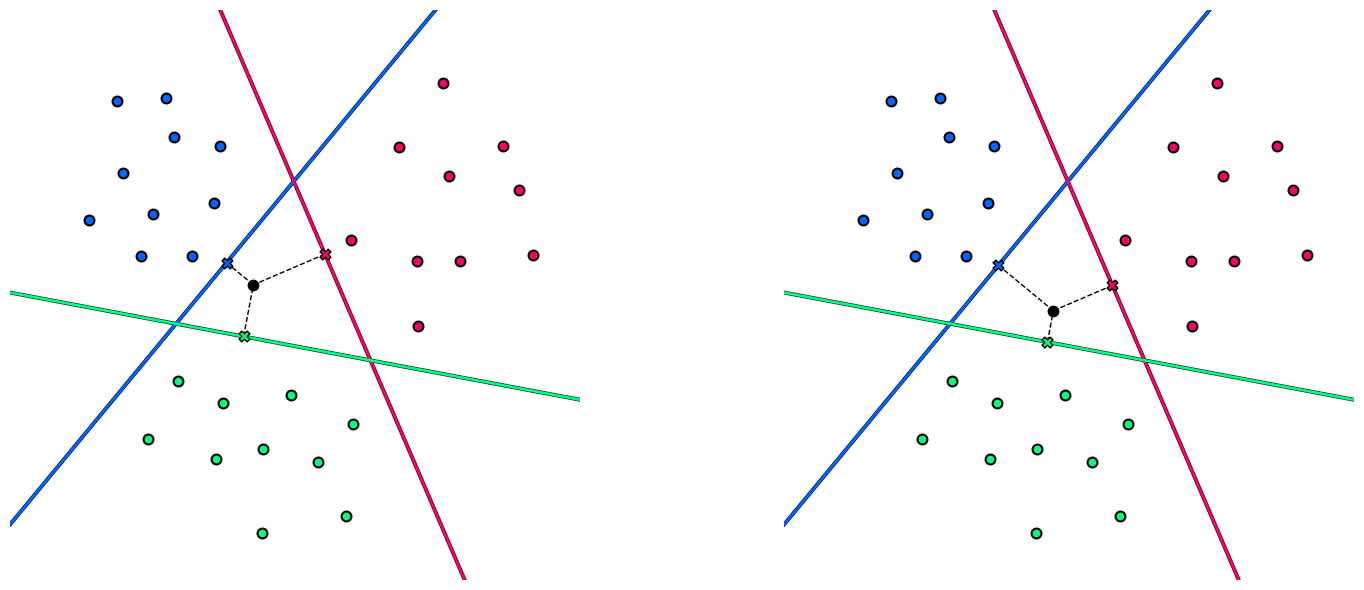

In [7]:
# try examining a point and its distance to relevant decision boundaries
demo1.point_and_projection(point1 = [0.4,0.5] ,point2 = [0.45,0.45])

Lets start with the point on the left. This point, like all those in the middle region, are on the negative side of all our classifiers. In other words, when trained, each of our $C$ two-class classifiers designated these points as *not* in their respective class. Thus we cannot argue - as we did at points on the positive side of multiple classifiers - that one classifier is more 'confident' in the class identity of such points. So what about the opposite question, i.e., which classifier is the least 'unsure' about the class identity of this point?  Which class is the point the least dissimilar spatially given our decision boundaries?  *Not* the boundary it is furthest from as was the case previously, but the one it is *closest* to. In the case of our example point on the left it lies closest to the red decision boundary - it is closest to being a red class point - hence we assign it to the red class.  

By the same reason our point on the right - which lies closest to the green decision boundary - is assigned to the green class. 

If we repeat this logic for every point in the region and color each point the color of its respective class, we will end up shading this region as shown by the Python cell below.

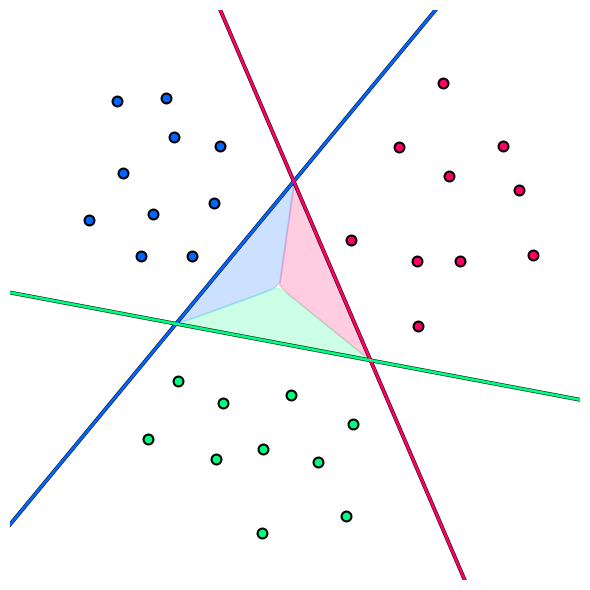

In [8]:
# color the region on which all classifiers are negative
demo1.show_fusion(region = 3);

As in the previous case, those points equidistant to two or more decision boundaries form the multi-class boundary and are assigned to a relevant class at random.

We can formalize this rule by noting that - once again - our reasoning has led us to assign a point to the class whose boundary is at the largest signed distance from it. Every point in the region lies on the negative side of our classifiers and all signed distances are negative. Hence the shortest distance *in magnitude* is the largest *signed* distance, being the smallest (in magnitude) negative number. Conversely the largest distance *in magnitude* is the largest (in magnitude) negative number, and hence the smallest *signed* distance.  

Thus once again (assuming the weights of our classifiers have been normalized) for an input point $\mathbf{x}$ we assign the label $y$ providing the maximum signed distance, i.e.,

\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c.
\end{equation}

##  Putting it all together

We have now deduced that the single rule for assigning a label $y$ to a point $\mathbf{x}$ 

\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c.
\end{equation}

which assigns the label based on the maximum signed distance of this point to each classifier, applies to the entire space of our problem (and - in general - to any multi-class problem). In fact this rule not only applies to the toy $C = 3$  dataset we have used in deriving the rule here, but to all multi-class datasets. Indeed we could have used any dataset (even those that are not completely separable) in our derivations here, as any multi-class problem can be broken down into the three fundamental regions we have seen in these derivations: regions where points are on the positive side of a single classifier, more than one classifier, or are on the negative side of all classifiers.

We call this the *fusion rule* - since it tells us precisely how to fuse our $C$ individual classifiers together to make a unified and consistent classification across the entire space of any dataset. It is the core of the *One-versus-All* algorithm, which we now state formally.

**Note:** In practice it is common to see implementations that skip the normalization in step 5.  This can theoretically lead to poor classification due to different sized normal vectors creating out of scale distance-to-clsasifier measurements.  However because often each classifier is trained using the same optimization framework - e.g., the same sized initialization and optimization algorithm - the resulting size of each trained normal vector can end up being around the same size (hence reducing the need for normalization).

### One-versus-All  multi-class classification

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>Input:</strong> multiclass dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$ where $y_{p}\in\left\{ 0,...,C-1\right\}$, two-class classification scheme and optimizer <br>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,j \, = \, 0,...,C-1$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; form temporary labels $\tilde y_p = \begin{cases}   +1 \,\,\,\,\,\,\text{if}\,\, y_p = j \\ -1 \,\,\,\,\,\,\text{if}\,\, y_p \neq j    \end{cases}$ <br><br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; solve two-class subproblem on $\left\{ \left(\mathbf{x}_{p,}\,\tilde y_{p}\right)\right\} _{p=1}^{P}$ to find weights $\mathbf{w}_j$
<br><br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; normalize classifier weights by magnitude of feature-touching portion $\mathbf{w}_{j}^{\,} \longleftarrow \frac{\mathbf{w}_{j}^{\,} }{\left\Vert \boldsymbol{\omega}_{j}^{\,} \right\Vert_2}$ 
<br>

<strong>6:</strong>&nbsp;&nbsp; <code>end for</code> <br>

<strong>7:</strong>&nbsp;&nbsp; To assign label $y$ to a point $\mathbf{x}$, apply the fusion rule: $y =  \underset{c\,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c$<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

Having addressed every region in the space of our exemplar dataset, one might wonder what the entire space looks like after learning the decision boundary. We plot this in the next Python cell. In both the left and right panels below we correctly classify and color the entire space as described above. In the left panel we show the three original two-class linear decision boundaries, and on the right we show the multi-class decision boundary (in black) created by fusing these individual boundaries using the fusion rule. This black multi-class boundary arises at points where the fusion rule does not provide a unique solution - i.e., at points where two or more classifiers provide the maximum evaluation.

The boundary resulting from the fusion rule is always piecewise-linear as with our example shown here. While the fusion rule explicitly defines this boundary it does not provide us with a closed form formula for it as with e.g., logistic regression (although one may work out a somewhat convoluted formula describing the boundary in general). In fact the piecewise-linear boundaries shown in the figures of this Section were drawn not by determining their formula but by labeling (and appropriately coloring) every point using the fusion rule.

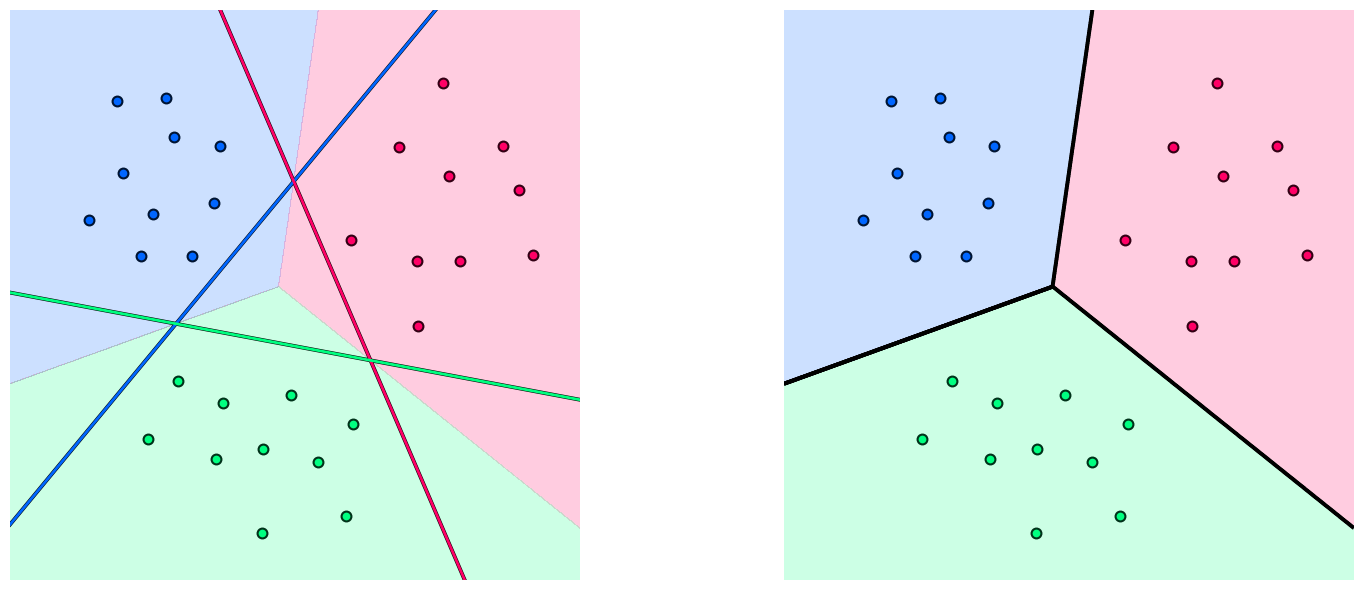

In [9]:
# classify and color the entire space using our individual classifiers and the fusion rule
demo1.show_complete_coloring();

## Implementing a One-versus-All classifier in `Python`

Since we have already discussed how to implement several two class classification schemes in the previous Chapter, here we will only describe an efficient way of implementing the *fusion rule* in `Python`.  

To take advantage of the `numpy` libraries fast array operations we use the notation first initroduced in [Section 5.6](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html), we stack the trained weights from our $C$ classifiers together into a single $\left(N + 1\right) \times C$ array of the form

\begin{equation}
\mathbf{W}=\begin{bmatrix} 
w_{0,0}  &  w_{0,1}  &  w_{0,2}  & \cdots   &  w_{0,C-1}  \\
w_{1,0}  &  w_{1,1}  &  w_{1,2}  & \cdots  &   w_{1,C-1}  \\
w_{2,0}  &  w_{2,1}  &  w_{2,2}  & \cdots  &  w_{2,C-1}  \\
\,\,\, {\vdots}_{\,\,\,}  & {\vdots}_{\,\,\,}  &  {\vdots}_{\,\,\,}  &  \cdots   &    {\vdots}_{\,\,\,}    \\
w_{N,0}  &  w_{N,1} & w_{N,2}  &  \cdots  &  w_{N,C-1}  \\
\end{bmatrix}
\end{equation}

Here the bias and normal vector of the $c^{th}$ classifier have been stacked on top of one another and make up the $c^{th}$ column of the array.  Now lets extend our `model` notation to also denote the evaluation of our $C$ individual linear models as


\begin{equation}
\begin{matrix} 
\text{model}\left(\mathbf{x},\mathbf{W}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{0}^{\,}   &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,}
\end{bmatrix}
\end{equation}

Note how this is precisely the same linear model used with multi-output regression as we saw in [Section 5.6](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html).  We can therefore re-use the implementation given there, which we repeat below.

In [10]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

Notice that we can now write the fusion rule in this extended `model` notation equivalently as 

\begin{equation}
y = \underset{c \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x},\mathbf{W}\right).
\end{equation}

Hence - based on the `Python` function for our `model` above - we can implement the fusion rule quite simply as shown below.

In [11]:
# the fusion rule
def fusion_rule(x,w):
    return np.argmax(model(x,w))

#### <span style="color:#a50e3e;">Example 1: </span> Classifying a dataset with $C = 4$ classes using OvA

In this example we quickly apply the OvA algorithm derived above to a toy dataset with $C=4$ classes shown below.

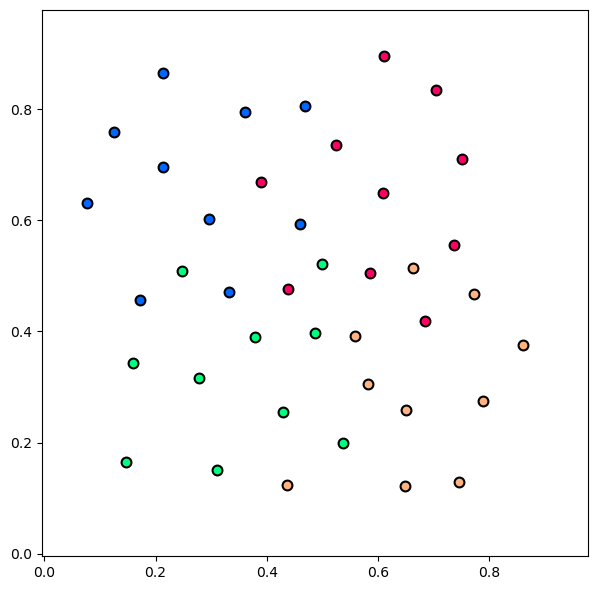

In [12]:
# load in dataset
data3 = np.loadtxt(dataset_path_2,delimiter = ',');

# create an instance of the ova demo
demo3 = section_7_2_helpers.OvaVsualizer(data3)

# visualize dataset
demo3.show_dataset();

Note with this dataset that each class is *not* linearly separable from the remainder of the data. This is no matter - the OvA framework still produces an appropriate multi-class boundary.  We solve our $C$ two-class subproblems.

With our subproblems solved we can use the fusion rule to classify our entire input space.  The Python cell below shows this printing out two panels with all points in the space colored according to the fusion rule in each panel.  The left panel also shows the individual learned two-class classifiers, while the right panel shows the final multi-class decision boundary, which does a fine job of distinguishing the four classes.

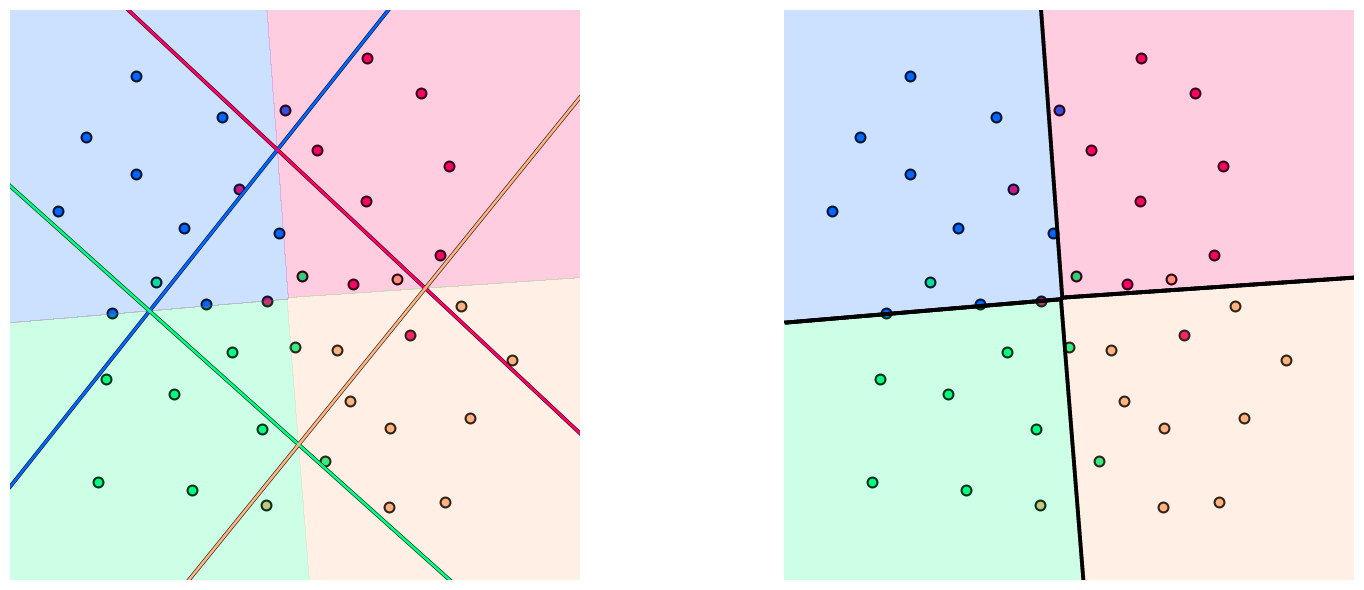

In [13]:
# solve the 2-class subproblems
demo3.solve_2class_subproblems()

# classify and color the entire space using our individual classifiers and the fusion rule
demo3.show_complete_coloring()

##   Interpreting the fusion rule as a discrete step function

In deriving the fusion rule above viewed the problem of multi-class classification 'from above', meaning (as detailed in e.g., [Section 6.2](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_2_Cross_entropy.html)) that we viewed our data in the input feature space coloring the value of each label instead of plotting our output as a dimension of the data.  However if we view our multi-class data 'from the side' we can indeed view the fusion rule as a *discrete step function for multi-class data*.  Further when using label values $y_p \in \left\{0,1,...,C-1\right\}$ this discrete step function takes on the same values.

We an visualize this discrete step function for the primary dataset employed in this Section by evaluating the fusion rule over a fine set of input values using the range of the data and visualizing the result.  Instead of visualizing these points 'from above' as we have been doing, and coloring them to denote class ownership, we can plot the result as a *surface* to visualze the fusion rule as a discrete step.  We show this below - in the left panel is our view of the data and fusion rule 'from above', and in the right panel is the same setup shown 'from the side' with the fusion rule displayed as a discrete step function.  Note that the jagged edges on some of the steps in the right panel are merely an artifact of the plotting mechanism (Python's matplotlib library) used to generate the three dimensional plot.  In reality the edges of each step are smooth like the fused decision boundary shown in the input space.

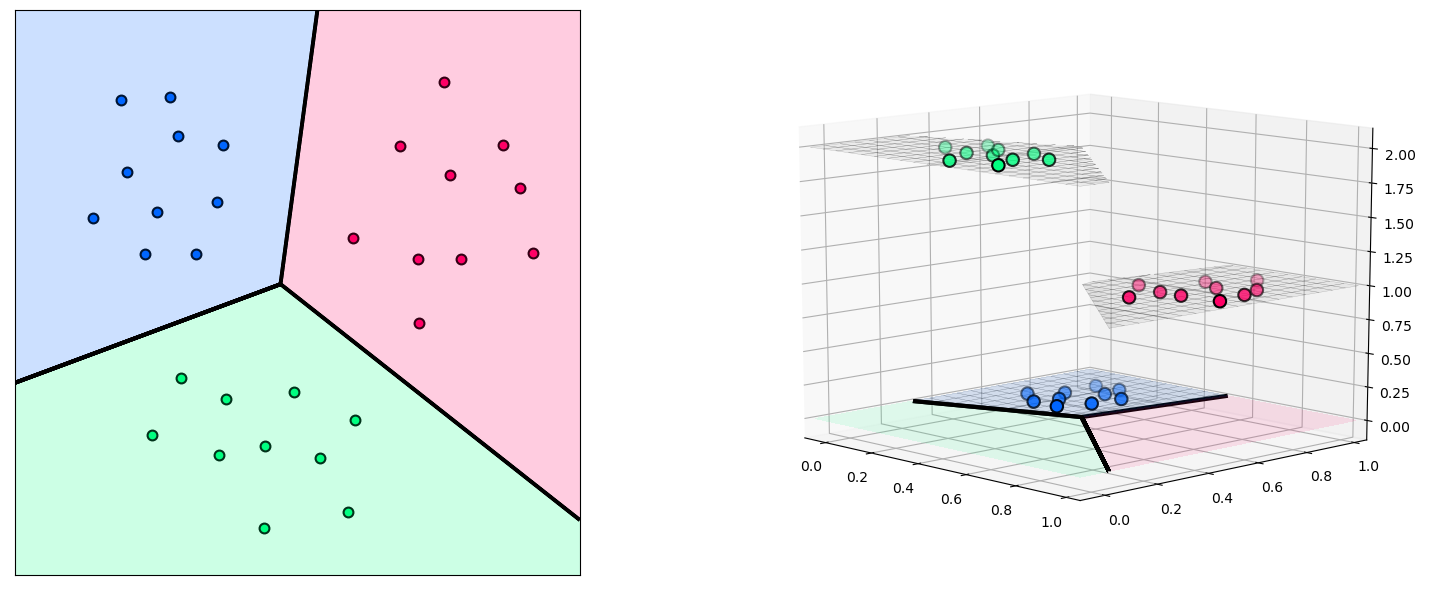

In [14]:
# load in dataset
data4 = np.loadtxt(dataset_path_1,delimiter = ',');

# create an instance of the ova demo
demo4 = section_7_2_helpers.OvaVsualizer(data4)

# solve the 2-class subproblems
demo4.solve_2class_subproblems()

# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo4.show_discrete_step([demo4.W.T],view = [12,-44])